In the following analysis we used the public dataset:

Llorens-Bobadilla, Enric, et al. "Single-cell transcriptomics reveals a population of dormant neural stem cells that become activated upon brain injury." Cell Stem Cell 17.3 (2015): 329-340.
http://dx.doi.org/10.1016/j.stem.2015.07.002

Processed data was downloaded from GEO website: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE67833

In [1]:
##############################################################
## ETH Zuerich, September 2018
## Authors: Anna Stopka, anna.stopka"at"bsse.ethz.ch
##          Marcelo Boareto, marcelo.boareto"at"bsse.ethz.ch
## 
## software: Python 2.7
##
##############################################################
## Code: read in and analysis of single-cell RNA-seq data
##
##############################################################

In [2]:
##############################################################
## 1) import libraries and define functions
##############################################################

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 
from scipy import stats
import scikits.bootstrap as boot

cmap = plt.cm.get_cmap('Blues')
%matplotlib inline

sns.set_style('white')
sns.set_context('notebook', font_scale=1.7, rc={'lines.linewidth': 1.3})

##### define path to the downloaded data:
path = '../rnaseqdata/' 

##### define functions:

# calculates the correlation between two genes
def pcorr(x,y, log_scale=False):
    if log_scale:
        x = np.log2(x)
        y = np.log2(y)
    [corr,p] = pearsonr(x, y)
    a,b   = np.polyfit(x, y, 1) 
    return [corr, p, a, b]

# resampling for bootstrap analysis
def resample(X, n=None):
    # the order of the values in a data set is changed (and also how often they occur)
    if n==None:
        n = np.shape(X)[1]
    resample_i = np.floor(np.random.rand(n)*np.shape(X)[1]).astype(int)
    X_resample = X[:,resample_i]
    return X_resample

# calculate the expression of a list of genes defined in D['list_genes] in the log2(X+1) scale
def get_expression(D):
    out = []
    for i in range(len(D['list_genes'])):
        out += [np.sum(D['data'].loc[D['list_genes'][i]].values, axis=0)]
    return np.log2(np.array(out)+1)

# convert ensembl ID to gene name
Xi = pd.read_csv(path+'data/Llorens_Bobadilla/Ensembl_IDs.txt', index_col=None, header=0)
def ensembl_to_geneID(Xi, g):
    return [[Xi[Xi['WikiGene Name']==i]['Ensembl Gene ID'].values[0] for i in g[j]] for j in range(len(g))]

In [3]:
##############################################################
## 2) read in data
##############################################################

X1 = pd.read_csv(path+'data/Llorens_Bobadilla/GSE67833_Gene_expression_matrix.csv',  
                 index_col=0, header=0)
X2 = pd.read_csv(path+'data/Llorens_Bobadilla/GSE67833_Gene_expression_matrix_GSM1684656-704.csv', 
                 index_col=0, header=0)

D = {}
D['data'] = pd.concat([X1, X2], axis=1, join='inner')
cl = pd.DataFrame(index=['cl'], columns=D['data'].columns)

# sorting for NSCs:
for i in cl.columns: 
    if i[0] == 'N':    # NSCs
        cl[i] = 0.0
    elif i[0] == 't':  # TAP cells
        cl[i] = 1.0

D['data']   = D['data'][cl.columns[cl.loc['cl']<=1]]
cl   = cl[cl.columns[cl.loc['cl']<=1]]
D['marker'] = np.array([str(i).replace('0.0','o').replace('1.0','>') for i in cl.values[0]])

print 'Number of NSC  =', np.sum(cl.values==0.0)
print 'Number of tap  =', np.sum(cl.values==1.0)
D['data'].head()

Number of NSC  = 130
Number of tap  = 27


,N1,N11,N13,N17,N18,N2,N22,N23,N24,N25,...,tap62,tap61,tap60,tap59,tap58,tap56,tap55,tap54,tap50,tap49
ENSMUSG00000099985,0.000,0.000,0.038,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ENSMUSG00000030105,16.498,0.000,0.089,0.00,63.615,0.068,312.755,88.253,76.513,0.000,...,58.356,64.274,115.027,0.000,94.013,137.899,74.606,91.661,101.311,139.724
ENSMUSG00000098001,0.509,0.252,0.051,0.43,0.264,0.361,0.168,0.122,0.190,0.327,...,0.940,0.486,1.629,0.135,0.498,0.893,0.305,0.000,0.591,0.327
ENSMUSG00000096054,0.000,0.511,0.000,0.00,0.000,0.090,0.042,3.288,0.000,57.626,...,0.097,0.045,0.092,0.000,0.000,0.045,0.000,0.000,0.357,0.187
ENSMUSG00000074445,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Number of NSCs with non-zero expression:  79


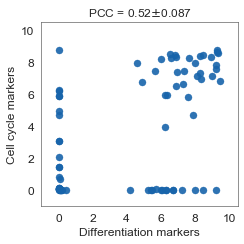

In [4]:
##############################################################
## 3) analyze and plot data
##############################################################

######### cell cycle marker and differentiaton marker expression
ccyc_markers = ['Mki67','Mcm2','Ccnd1']
diff_markers = ['Ascl1','Neurog2','Neurod2']

D['list_genes'] = ensembl_to_geneID(Xi,[diff_markers, ccyc_markers])
x_data = get_expression(D)

x = x_data[0][(D['marker']=='o')]
y = x_data[1][(D['marker']=='o')]

X = x_data[:,(D['marker']=='o')]

#### exclude data points that are zero in either axis
#X = X[:, (X[0] > 0.0)]  # exclude data points with 0
#X = X[:, (X[1] > 0.0)]  # exclude data points with 0

####exclude (0,0) data points
X = X[:,np.sum(X,axis=0)>0.0] 

print 'Number of NSCs with non-zero expression: ',len(X[0])

# correlation:
corr = round(pcorr(X[0][(X[0]+X[1])>0],X[1][(X[0]+X[1])>0])[0],3)

# bootstrap analysis
n_sampling = 1000
pcc = np.zeros((1, n_sampling))
for i in range(n_sampling):
    Xs = resample(X)
    pcc[:,i] = round(pcorr(Xs[0][(Xs[0]+Xs[1])>0],Xs[1][(Xs[0]+Xs[1])>0])[0],3)
pcc_m = np.round(np.mean(pcc,axis=1),3)
pcc_s = np.round(np.std(pcc,axis=1),3)

# plotting

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3.5, 3.5)

ax.scatter(X[0], X[1], cmap=cmap, c=cmap(0.8), marker='o', s=50, alpha=0.9)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
ax.set_xlim([-1, 10.5])
ax.set_ylim([-1, 10.5])
ax.set_xticks([0,2.,4.,6.,8.,10.])
ax.set_yticks([0,2.,4.,6.,8.,10.])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Differentiation markers', fontsize =12)
ax.set_ylabel('Cell cycle markers', fontsize =12)
ax.set_title('PCC = '+ str(pcc_m[0]) + r'$ \pm $' + str(pcc_s[0]), fontsize =12)

plt.tight_layout()
plt.show()